In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.constants import c
from scipy.integrate import quad

#Nested sampling package
import ultranest
import corner

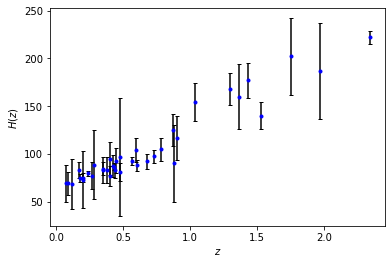

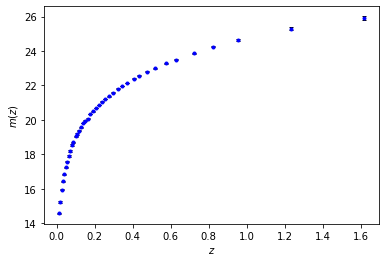

In [2]:
# Import Hubble H(z) data

hubble_data = pd.read_csv('hubble_data.csv', header=0)

z_H = np.array(hubble_data['z'])
H = np.array(hubble_data['H'])
dH = np.array(hubble_data['dH'])

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

# Import apparent magnitude m(z) data
m_data = pd.read_csv('m_data.txt', sep = ' ', header = 0)
m_sys_unc = pd.read_csv('m_sys_unc.txt', sep = ' ', header = 0)
m_sys_unc = np.array(m_sys_unc['40']).reshape(40, 40)

tot = m_sys_unc + np.diag(m_data['dmb']**2)

z_m = np.array(m_data['zcmb'])
m = np.array(m_data['mb'])
dm = np.sqrt(np.diag(tot))

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# Combine redshifts for likelihood computation later
combined_z = []
combined_z.append(z_H)
combined_z.append(z_m)

# Combine data
combined_data = []
combined_data.append(H)
combined_data.append(m)

# Combine uncertainties
combined_unc = []
combined_unc.append(dH)
combined_unc.append(dm)

In [3]:
'Define LCDM Hubble model'
def LCDM(z, params):
    H0 = params[0] 
    OM = params[1]
    OL = params[2]
    
    return H0*np.sqrt(OM*(1+z)**3 + OL)

'Define Domain Walls Model'
def DomainWalls(z, params):
    H0 = params[0] 
    OM = params[1] 
    OD = params[2]
    
    return H0*np.sqrt(OM*(1+z)**3 + OD*(1+z)**(1/3))

'Define Cosmic Strings Model'
def CosmicStrings(z, params):
    H0 = params[0] 
    OM = params[1] 
    OS = params[2]
    return H0*np.sqrt(OM*(1+z)**3 + OS*(1+z)**(1/3))

'Define Phantom Energy Model'
def PhantomEnergy(z, params):
    H0 = params[0] 
    OM = params[1] 
    OP = params[2]
    w_p = params[3]

    return H0*np.sqrt(OM*(1+z)**3 + OP*(1+z)**(3*(1+w_p)))

'Define Inverse Monomial model'
def InverseMonomial(z, params):
    H0 = params[0] 
    B = params[1]
    
    return H0*np.sqrt((1/(1+B*z))*(1+z)**3)

'Define Exponential Model'
def Exponential(z, params):
    H0 = params[0] 
    B = params[1]
    
    return H0*np.sqrt(np.exp(B*((1/(1+z))-1))*(1+z)**3)
                      
'Define Logarithmic Model'
def LogarithmicModel(z, params):
    H0 = params[0] 
    B = params[1]
    
    return H0*np.sqrt((B*np.log(1/(1+z)) + 1)*(1+z)**3)

'Define backreaction Model'
def backreaction(z, params):
    H0 = params[0] 
    OM = params[1] 
    n = params[2]
    
    return H0*np.sqrt(OM*((1+z)**3)+(1-OM)*((1+z)**n))

'Define apparent magnitude function'
def ApparentMagnitude(z, Hubble, params):
    
    def integrand_dl(z, Hubble, params):
    #integrand of luminosity distance formula
        return params[0]/Hubble(z, params)

    def dl(z, Hubble, params):
    #dimensionless luminosity distance at redshift z (input array)
        rz_array = np.zeros(len(z))  
        for i in np.arange(len(z)):
            rz_each = quad( integrand_dl, 0, z[i],
                        args = (Hubble, params) )[0]
            rz_array[i] = rz_each
            
        return (1+z)*rz_array
    
    return 5*np.log10((c*100/params[0])*dl(z, Hubble, params)) - 19.25

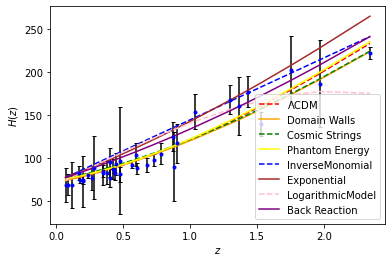

In [7]:
params_lcdm = [72.21, 0.26, 0.74]
params_domainwalls = [73.37, 0.22, 0.73]
params_cosmicstrings = [74.96, 0.21, 0.75]
params_phantomenergy = [74.50, 0.25, 0.73, -1.03]
params_InverseMonomial = [72.21, 1]
params_Exponential = [73.37, 1.5]
params_LogarithmicModel = [68.47, 0.6834 ]
params_backreaction = [73.37, 0.22, 1]

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_H, LCDM(z_H, params_lcdm), color='red', ls='--', label=r'$\Lambda$CDM')
plt.plot(z_H, DomainWalls(z_H, params_domainwalls), color='orange', label='Domain Walls')
plt.plot(z_H, CosmicStrings(z_H, params_cosmicstrings), color='green', ls='--', label='Cosmic Strings')
plt.plot(z_H, PhantomEnergy(z_H, params_phantomenergy), color='yellow', label='Phantom Energy')
plt.plot(z_H, InverseMonomial(z_H, params_InverseMonomial), color='blue', ls='--', label='InverseMonomial')
plt.plot(z_H, Exponential(z_H, params_Exponential), color='brown', label='Exponential')
plt.plot(z_H, LogarithmicModel(z_H, params_LogarithmicModel), color='pink', ls='--', label='LogarithmicModel')
plt.plot(z_H, backreaction(z_H, params_backreaction), color='purple', label='Back Reaction')
plt.legend(loc='best')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.savefig('H(z) vs z.pdf')
plt.show()

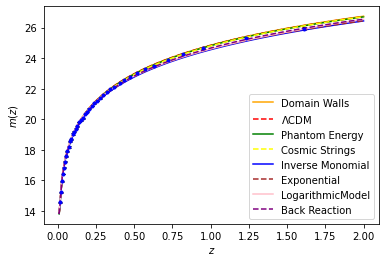

In [8]:
plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
z_m2 = np.linspace(0.01,2,100)
plt.plot(z_m2, ApparentMagnitude(z_m2, DomainWalls, params_domainwalls), color='orange', label='Domain Walls')
plt.plot(z_m2, ApparentMagnitude(z_m2, LCDM, params_lcdm), color='red', ls='--', label=r'$\Lambda$CDM')
plt.plot(z_m2, ApparentMagnitude(z_m2, PhantomEnergy, params_phantomenergy), color='green', label='Phantom Energy')
plt.plot(z_m2, ApparentMagnitude(z_m2, CosmicStrings, params_cosmicstrings), color='yellow', ls='--', label='Cosmic Strings')
plt.plot(z_m2, ApparentMagnitude(z_m2, InverseMonomial, params_InverseMonomial), color='blue', label='Inverse Monomial')
plt.plot(z_m2, ApparentMagnitude(z_m2, Exponential, params_Exponential), color='brown', ls='--', label='Exponential')
plt.plot(z_m2, ApparentMagnitude(z_m2, LogarithmicModel, params_LogarithmicModel), color='pink', label='LogarithmicModel')
plt.plot(z_m2, ApparentMagnitude(z_m2, backreaction, params_backreaction), color='purple', ls='--', label='Back Reaction')
plt.legend(loc='best')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.savefig('m(z) vs z.pdf')
plt.show()

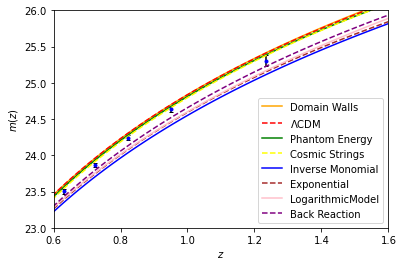

In [9]:
plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_m2, ApparentMagnitude(z_m2, DomainWalls, params_domainwalls), color='orange', label='Domain Walls')
plt.plot(z_m2, ApparentMagnitude(z_m2, LCDM, params_lcdm), color='red', ls='--', label=r'$\Lambda$CDM')
plt.plot(z_m2, ApparentMagnitude(z_m2, PhantomEnergy, params_phantomenergy), color='green', label='Phantom Energy')
plt.plot(z_m2, ApparentMagnitude(z_m2, CosmicStrings, params_cosmicstrings), color='yellow', ls='--', label='Cosmic Strings')
plt.plot(z_m2, ApparentMagnitude(z_m2, InverseMonomial, params_InverseMonomial), color='blue', label='Inverse Monomial')
plt.plot(z_m2, ApparentMagnitude(z_m2, Exponential, params_Exponential), color='brown', ls='--', label='Exponential')
plt.plot(z_m2, ApparentMagnitude(z_m2, LogarithmicModel, params_LogarithmicModel), color='pink', label='LogarithmicModel')
plt.plot(z_m2, ApparentMagnitude(z_m2, backreaction, params_backreaction), color='purple', ls='--', label='Back Reaction')
plt.legend(loc='best')
plt.xlim(0.6,1.6)
plt.ylim(23,26)
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.savefig('m(z) vs z zoomed.pdf')
plt.show()